<a href="https://colab.research.google.com/github/mmmchai/superstore-rfm-clustering/blob/main/Superstore_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superstore Customer Segmentation
### Context
In a highly competitive retail environment, understanding customer purchasing behavior is critical for driving business growth. However, without a structured approach to customer segmentation, businesses struggle to identify high-value customers, optimize marketing strategies, and improve customer retention.


### Objective
This analysis applies Recency, Frequency, and Monetary (RFM) segmentation to the Superstore dataset to categorize customers into distinct clusters. By leveraging these insights, we aim to:
*  Identify high-value customers for targeted marketing efforts.
*  Detect at-risk customers to improve retention strategies.


### Notes
* Recency: How recently has the customer made a purchase
* Frequency: How frequent is the customer in buying
* Monetary: How much does the customer spend

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
file_path = "/content/drive/MyDrive/Interview Prep/Portfolio/Customer Segmentation/Sample - Superstore.xls"

In [ ]:
df = pd.read_excel(file_path)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,2020-11-08,2020-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,2020-11-08,2020-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,2020-06-12,2020-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,2019-10-11,2019-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,2019-10-11,2019-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
cols = ['Order ID', 'Order Date', 'Customer ID', 'Customer Name', 'Category','Sales', 'Quantity', 'Discount', 'Profit']
df = df[cols]

In [ ]:
df.head(5).sort_values(by='Customer Name')

,Order ID,Order Date,Customer ID,Customer Name,Category,Sales,Quantity,Discount,Profit
0,CA-2020-152156,2020-11-08,CG-12520,Claire Gute,Furniture,261.9600,2,0.00,41.9136
1,CA-2020-152156,2020-11-08,CG-12520,Claire Gute,Furniture,731.9400,3,0.00,219.5820
2,CA-2020-138688,2020-06-12,DV-13045,Darrin Van Huff,Office Supplies,14.6200,2,0.00,6.8714
3,US-2019-108966,2019-10-11,SO-20335,Sean O'Donnell,Furniture,957.5775,5,0.45,-383.0310
4,US-2019-108966,2019-10-11,SO-20335,Sean O'Donnell,Office Supplies,22.3680,2,0.20,2.5164


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Customer ID    9994 non-null   object        
 3   Customer Name  9994 non-null   object        
 4   Category       9994 non-null   object        
 5   Sales          9994 non-null   float64       
 6   Quantity       9994 non-null   int64         
 7   Discount       9994 non-null   float64       
 8   Profit         9994 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 702.8+ KB


In [ ]:
#check for missing values
df.isna().sum().to_list()

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#check for duplicated rows
df.duplicated().sum()

1

# EDA Summary

In [ ]:
df['Total Sales'] = df['Sales'] * df['Quantity']

print("Data range:", df['Order Date'].min(), "-->", df['Order Date'].max())

print("Unique Customers:", df['Customer ID'].nunique())

print("Total Sales:", (df['Total Sales'].sum()).round(2))

print("# of Transactions:", df['Order ID'].count())

print("Average basket size:", (df['Total Sales'].sum() / df['Order ID'].count()).round(2))

Data range: 2018-01-03 00:00:00 --> 2021-12-30 00:00:00
Unique Customers: 793
Total Sales: 11488062.07
# of Transactions: 9994
Average basket size: 1149.5


# Prepare RFM Data

## Recency

In [ ]:
df_recency = df.groupby(by='Customer Name', as_index=False)['Order Date'].max()
df_recency.rename(columns={'Order Date': 'Last Purchase Date'}, inplace=True)

# most recent order date
recent_date = df['Order Date'].max()
recent_date

Timestamp('2021-12-30 00:00:00')

In [ ]:
# calculate recency in days
df_recency['Recency'] = df_recency['Last Purchase Date'].apply(lambda x: (recent_date - x).days)
df_recency.head(5)

,Customer Name,Last Purchase Date,Recency
0,Aaron Bergman,2020-11-10,415
1,Aaron Hawkins,2021-12-18,12
2,Aaron Smayling,2021-10-03,88
3,Adam Bellavance,2021-11-06,54
4,Adam Hart,2021-11-26,34


In [ ]:
df_recency.shape

(793, 3)

## Frequency

In [ ]:
df_freq = df.groupby(by='Customer Name', as_index=False)['Order ID'].count()
df_freq.rename(columns={'Order ID': 'Frequency'}, inplace=True)
df_freq.head(5)

,Customer Name,Frequency
0,Aaron Bergman,6
1,Aaron Hawkins,11
2,Aaron Smayling,10
3,Adam Bellavance,18
4,Adam Hart,20


In [ ]:
df_freq.shape

(793, 2)

## Monetary

In [ ]:
df['Total Sales'] = df['Sales'] * df['Quantity']

df_monetary = df.groupby(by='Customer Name', as_index=False)['Total Sales'].sum()
df_monetary.rename(columns={'Total Sales': 'Monetary'}, inplace=True)
df_monetary.head(5)

,Customer Name,Monetary
0,Aaron Bergman,1984.480
1,Aaron Hawkins,11459.552
2,Aaron Smayling,9088.880
3,Adam Bellavance,35390.580
4,Adam Hart,9664.265


In [ ]:
df_monetary.shape

(793, 2)

In [ ]:
df_rfm = pd.merge(df_recency, df_freq, on='Customer Name')
df_rfm = pd.merge(df_rfm, df_monetary, on='Customer Name')

In [ ]:
df_rfm.drop(columns=['Last Purchase Date'], inplace=True)

## Final RFM Dataset

In [ ]:
df_rfm.head(5)

,Customer Name,Recency,Frequency,Monetary
0,Aaron Bergman,415,6,1984.480
1,Aaron Hawkins,12,11,11459.552
2,Aaron Smayling,88,10,9088.880
3,Adam Bellavance,54,18,35390.580
4,Adam Hart,34,20,9664.265


# RFM Score
Business rules to calculate RFM Score

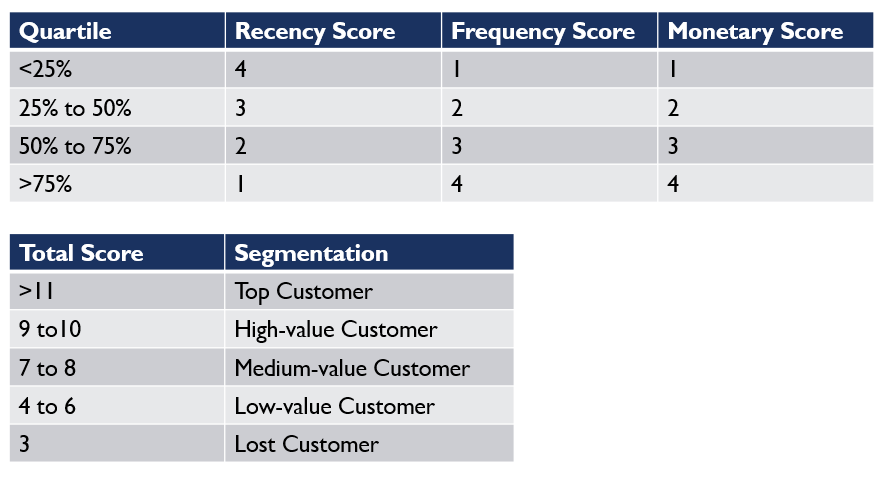

## RFM Score Code

In [ ]:
df_rfm_score = df_rfm.copy()

In [ ]:
df_rfm_quartiles = df_rfm[['Frequency', 'Recency', 'Monetary']].quantile(q = [0.25, 0.5, 0.75])
df_rfm_quartiles

,Frequency,Recency,Monetary
0.25,8.0,30.0,4768.010
0.50,12.0,75.0,9974.654
0.75,16.0,183.0,18527.648


In [ ]:
# Recency Score, 1 to 4 (good to bad)
col_name = 'Recency'
score_name = 'Recency_score'

df_rfm_score.loc[df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.25], score_name] = 4
df_rfm_score.loc[(df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.25]) & (df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.50]), score_name] = 3
df_rfm_score.loc[(df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.50]) & (df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.75]), score_name] = 2
df_rfm_score.loc[df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.75], score_name] = 1

In [ ]:
# Frequency Score, 1 to 4 (bad to good)
col_name = 'Frequency'
score_name = 'Frequency_score'

df_rfm_score.loc[df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.25], score_name] = 1
df_rfm_score.loc[(df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.25]) & (df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.50]), score_name] = 2
df_rfm_score.loc[(df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.50]) & (df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.75]), score_name] = 3
df_rfm_score.loc[df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.75], score_name] = 4

In [ ]:
# Monetary Score, 1 to 4 (bad to good)
col_name = 'Monetary'
score_name = 'Monetary_score'

df_rfm_score.loc[df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.25], score_name] = 1
df_rfm_score.loc[(df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.25]) & (df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.50]), score_name] = 2
df_rfm_score.loc[(df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.50]) & (df_rfm_score[col_name] <= df_rfm_quartiles[col_name][0.75]), score_name] = 3
df_rfm_score.loc[df_rfm_score[col_name] > df_rfm_quartiles[col_name][0.75], score_name] = 4

In [ ]:
df_rfm_score['rfm_score'] = df_rfm_score['Recency_score'] + df_rfm_score['Frequency_score'] + df_rfm_score['Monetary_score']

In [ ]:
df_rfm_score.head(5)

,Customer Name,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,rfm_score
0,Aaron Bergman,415,6,1984.480,1.0,1.0,1.0,3.0
1,Aaron Hawkins,12,11,11459.552,4.0,2.0,3.0,9.0
2,Aaron Smayling,88,10,9088.880,2.0,2.0,2.0,6.0
3,Adam Bellavance,54,18,35390.580,3.0,4.0,4.0,11.0
4,Adam Hart,34,20,9664.265,3.0,4.0,2.0,9.0


In [ ]:
df_rfm_score.loc[(df_rfm_score['rfm_score'] >= 11.0), 'Segment'] = 1
df_rfm_score.loc[(df_rfm_score['rfm_score'] >= 9.0) & (df_rfm_score['rfm_score'] <= 10.0), 'Segment'] = 2
df_rfm_score.loc[(df_rfm_score['rfm_score'] >= 7.0) & (df_rfm_score['rfm_score'] <= 8.0), 'Segment'] = 3
df_rfm_score.loc[(df_rfm_score['rfm_score'] >= 4.0) & (df_rfm_score['rfm_score'] <= 6.0), 'Segment'] = 4
df_rfm_score.loc[(df_rfm_score['rfm_score'] == 3.0), 'Segment'] = 5

segment = [1,2,3,4,5]
segment_name = ['Top Customers', 'High-value Customers', 'Medium-value Customers', 'Low-value Customers', 'Lost Customers']
df_rfm_score['Segment Name'] = df_rfm_score['Segment'].replace(segment, segment_name)

In [ ]:
df_rfm_score.head(5)

,Customer Name,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,rfm_score,Segment,Segment Name
0,Aaron Bergman,415,6,1984.480,1.0,1.0,1.0,3.0,5.0,Lost Customers
1,Aaron Hawkins,12,11,11459.552,4.0,2.0,3.0,9.0,2.0,High-value Customers
2,Aaron Smayling,88,10,9088.880,2.0,2.0,2.0,6.0,4.0,Low-value Customers
3,Adam Bellavance,54,18,35390.580,3.0,4.0,4.0,11.0,1.0,Top Customers
4,Adam Hart,34,20,9664.265,3.0,4.0,2.0,9.0,2.0,High-value Customers


In [ ]:
df_rfm_score.groupby(by=['Segment','Segment Name'], as_index=False)[['Recency','Frequency','Monetary']].mean().round(2).sort_values(by='Segment')

,Segment,Segment Name,Recency,Frequency,Monetary
0,1.0,Top Customers,25.37,20.70,30050.04
1,2.0,High-value Customers,72.90,16.69,22053.28
2,3.0,Medium-value Customers,120.94,11.82,13708.34
3,4.0,Low-value Customers,202.22,8.39,5654.08
4,5.0,Lost Customers,467.54,4.98,1818.84


## Plot RFM Score Segmentation

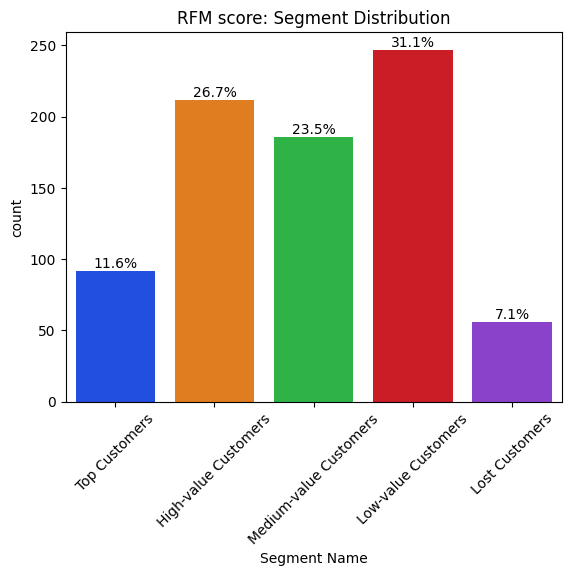

In [ ]:
total = len(df_rfm_score)

ax = sns.countplot(data=df_rfm_score, x='Segment Name', palette='bright', order=segment_name)

for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')

plt.title('RFM score: Segment Distribution')
plt.xticks(rotation=45)
plt.show()

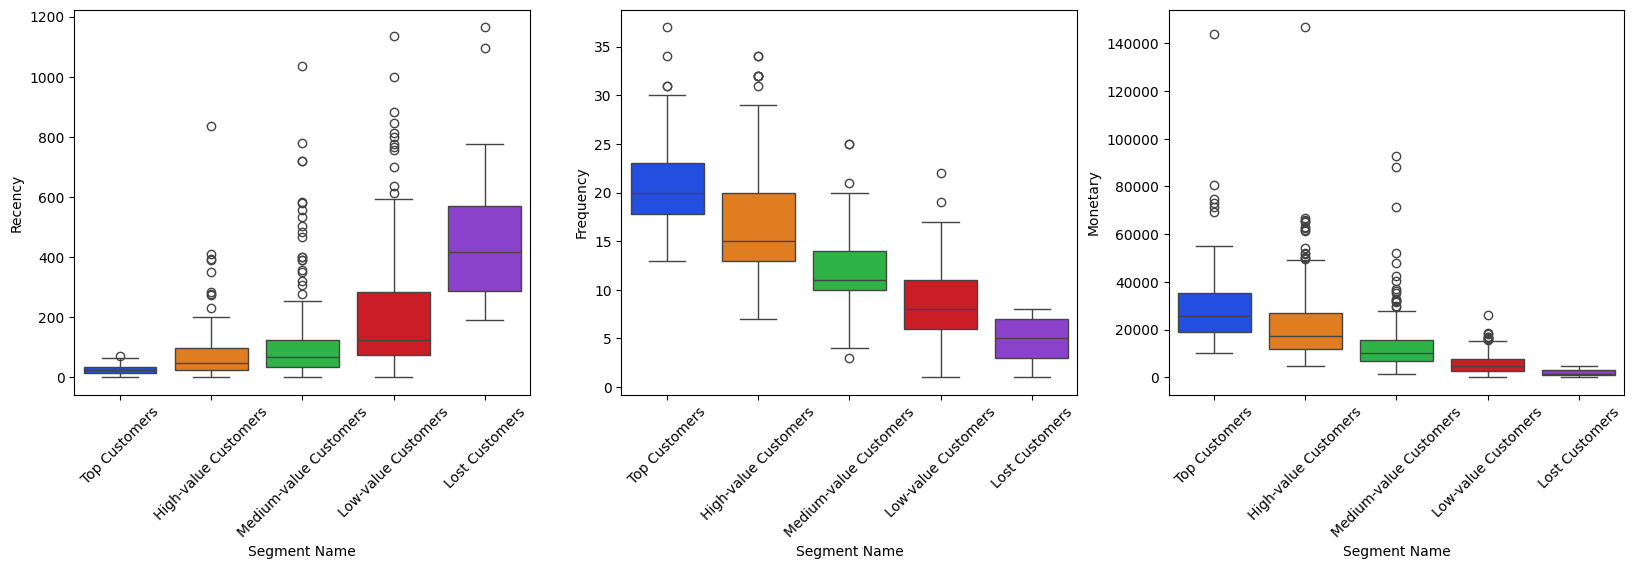

In [ ]:
# Plotting data
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(data=df_rfm_score, x='Segment Name', y = 'Recency', order=segment_name, palette='bright', ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

sns.boxplot(data=df_rfm_score, x='Segment Name', y = 'Frequency', order=segment_name, palette='bright', ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

sns.boxplot(data=df_rfm_score, x='Segment Name', y = 'Monetary', order=segment_name, palette='bright', ax=axs[2])
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)


plt.show()

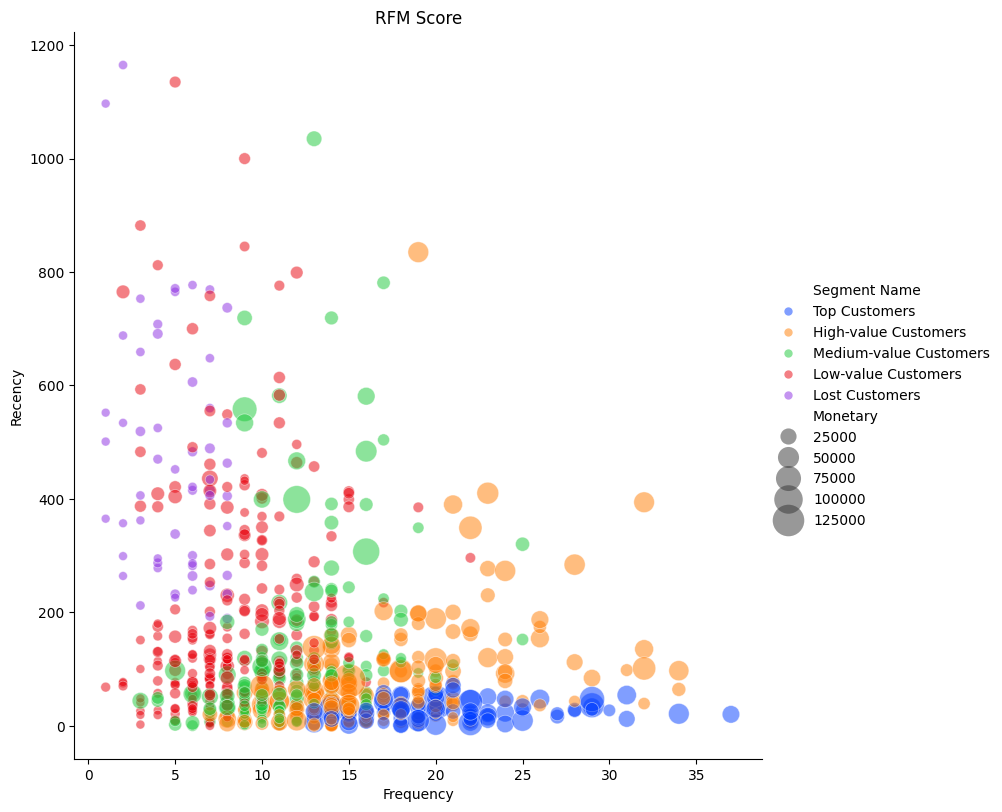

In [ ]:
sns.relplot(data=df_rfm_score, x="Frequency", y="Recency", size="Monetary",
            hue="Segment Name", hue_order=segment_name,
            sizes=(40, 600),alpha=.5, palette="bright", height=8)

plt.title('RFM Score')
plt.show()

# Unsupervised learning - Clustering


## Normalize Data

In [ ]:
df_rfm_cluster = df_rfm.copy()

<Axes: xlabel='Monetary', ylabel='Count'>

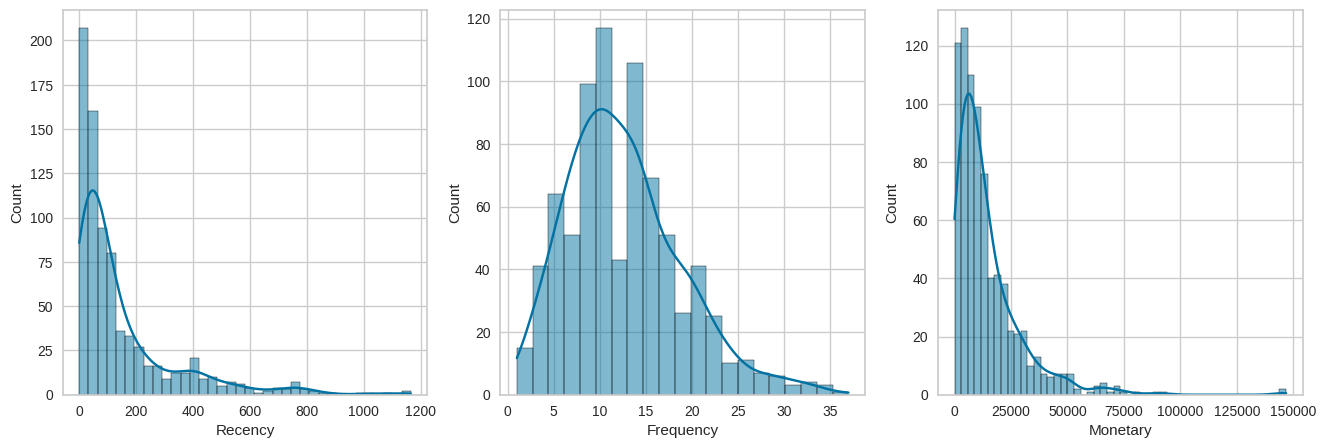

In [ ]:
# Plotting data
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
sns.histplot(df_rfm_cluster['Recency'], ax  = axs[0], kde=True)
sns.histplot(df_rfm_cluster['Frequency'], ax  = axs[1], kde=True)
sns.histplot(df_rfm_cluster['Monetary'], ax  = axs[2], kde=True)

In [ ]:
#Scale all three using yeo-jonson method

from sklearn import preprocessing
scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(df_rfm_cluster[['Frequency']])
df_rfm_cluster['frequency_yj'] = scaler.transform(df_rfm_cluster[['Frequency']])

scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(df_rfm_cluster[['Recency']])
df_rfm_cluster['recency_yj'] = scaler.transform(df_rfm_cluster[['Recency']])

scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(df_rfm_cluster[['Monetary']])
df_rfm_cluster['monetary_yj'] = scaler.transform(df_rfm_cluster[['Monetary']])

<Axes: xlabel='monetary_yj', ylabel='Count'>

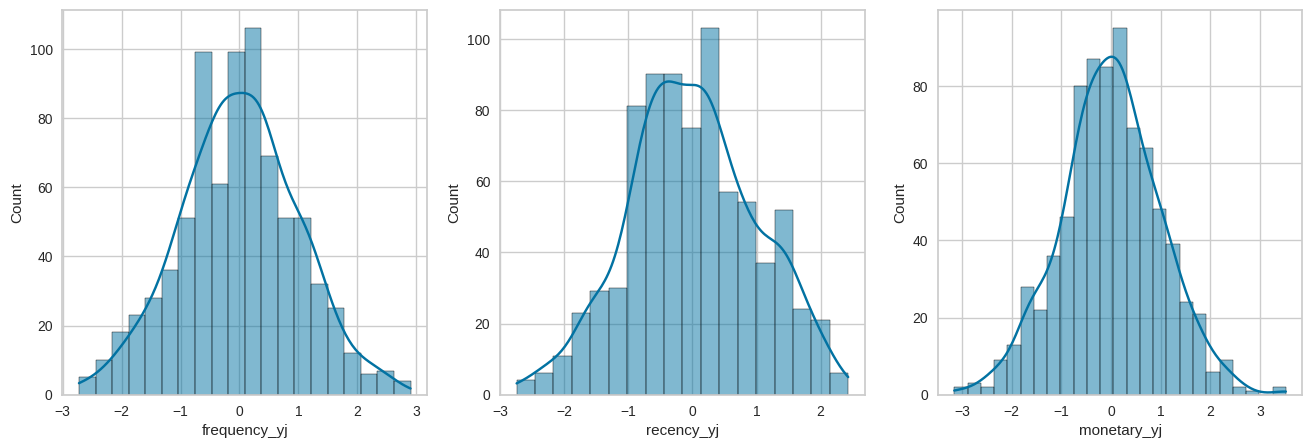

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
sns.histplot(df_rfm_cluster['recency_yj'], ax  = axs[1], kde=True)
sns.histplot(df_rfm_cluster['frequency_yj'], ax  = axs[0], kde=True)
sns.histplot(df_rfm_cluster['monetary_yj'], ax  = axs[2], kde=True)

In [ ]:
#Scale all three using Standard scaler
scaler = preprocessing.StandardScaler()

df_rfm_cluster[['Recency_ss', 'Frequency_ss', 'Monetary_ss']] = scaler.fit_transform(df_rfm_cluster[['Recency', 'Frequency', 'Monetary']])

<Axes: xlabel='Monetary_ss', ylabel='Count'>

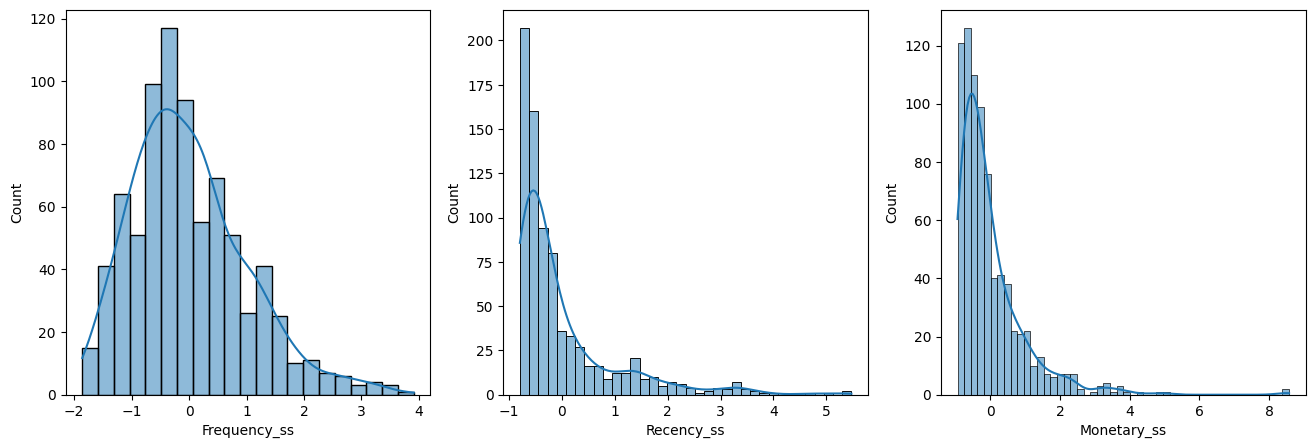

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
sns.histplot(df_rfm_cluster['Recency_ss'], ax  = axs[1], kde=True)
sns.histplot(df_rfm_cluster['Frequency_ss'], ax  = axs[0], kde=True)
sns.histplot(df_rfm_cluster['Monetary_ss'], ax  = axs[2], kde=True)

In [ ]:
#Scale all three using Log transformation
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
df_rfm_cluster[['Recency_log', 'Frequency_log', 'Monetary_log']] = transformer.fit_transform(df_rfm_cluster[['Recency', 'Frequency', 'Monetary']])

<Axes: xlabel='Monetary_log', ylabel='Count'>

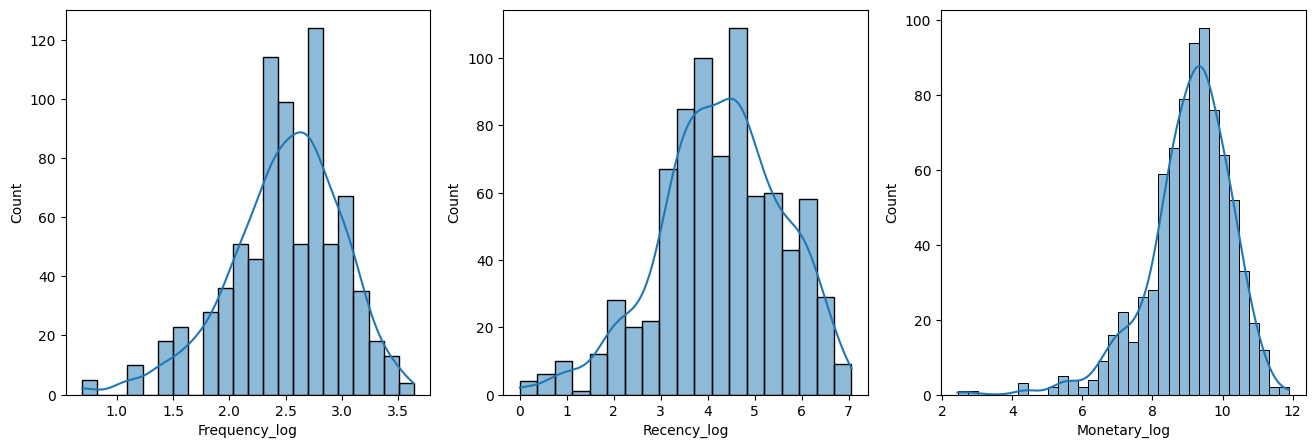

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
sns.histplot(df_rfm_cluster['Recency_log'], ax  = axs[1], kde=True)
sns.histplot(df_rfm_cluster['Frequency_log'], ax  = axs[0], kde=True)
sns.histplot(df_rfm_cluster['Monetary_log'], ax  = axs[2], kde=True)

In [ ]:
df_rfm_cluster.drop(columns=['Recency_ss', 'Frequency_ss', 'Monetary_ss','Recency_log','Frequency_log','Monetary_log'], inplace=True)

In [ ]:
df_rfm_cluster.head(5)

,Customer Name,Recency,Frequency,Monetary,frequency_yj,recency_yj,monetary_yj
0,Aaron Bergman,415,6,1984.480,-1.118419,1.422079,-1.251270
1,Aaron Hawkins,12,11,11459.552,-0.127489,-1.279994,0.136221
2,Aaron Smayling,88,10,9088.880,-0.302776,0.100517,-0.081831
3,Adam Bellavance,54,18,35390.580,0.910526,-0.270888,1.385767
4,Adam Hart,34,20,9664.265,1.163972,-0.603335,-0.025241


In [ ]:
#Final dataframe for RFM modelling
df_rfm_clean = df_rfm_cluster[['frequency_yj','recency_yj','monetary_yj']]

In [ ]:
df_rfm_clean.head(5)

,frequency_yj,recency_yj,monetary_yj
0,-1.118419,1.422079,-1.251270
1,-0.127489,-1.279994,0.136221
2,-0.302776,0.100517,-0.081831
3,0.910526,-0.270888,1.385767
4,1.163972,-0.603335,-0.025241


## Kmeans

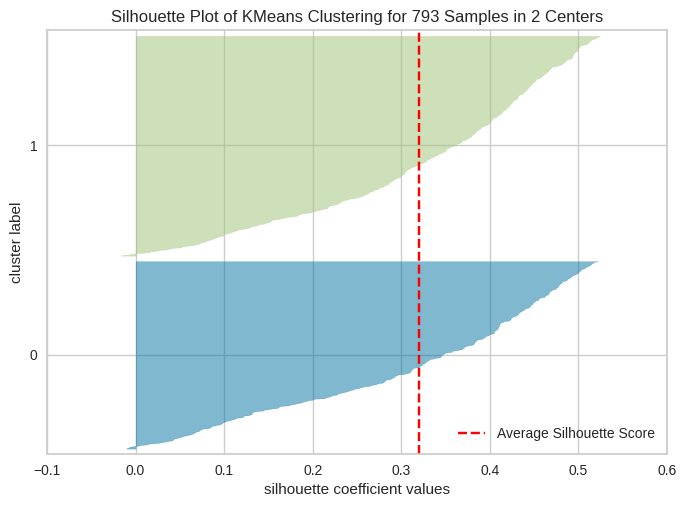

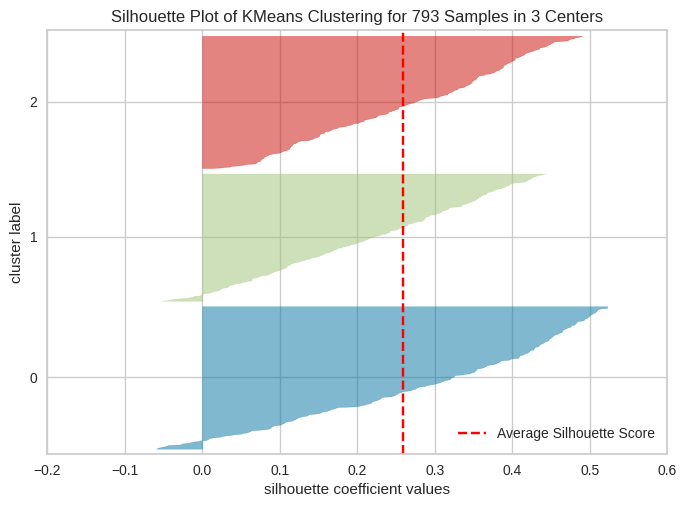

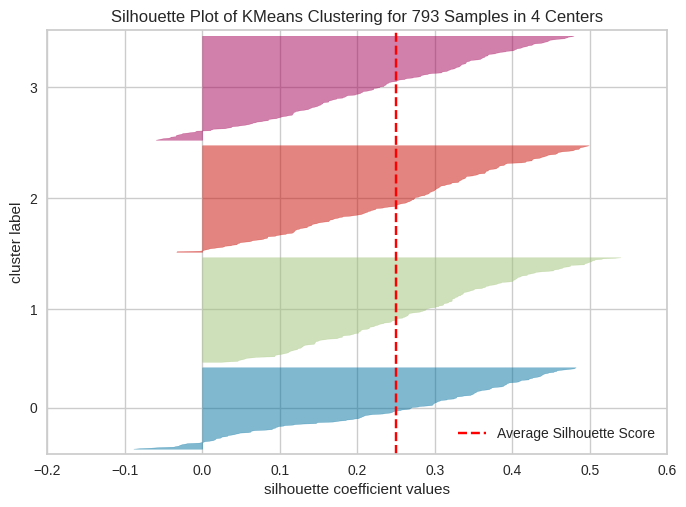

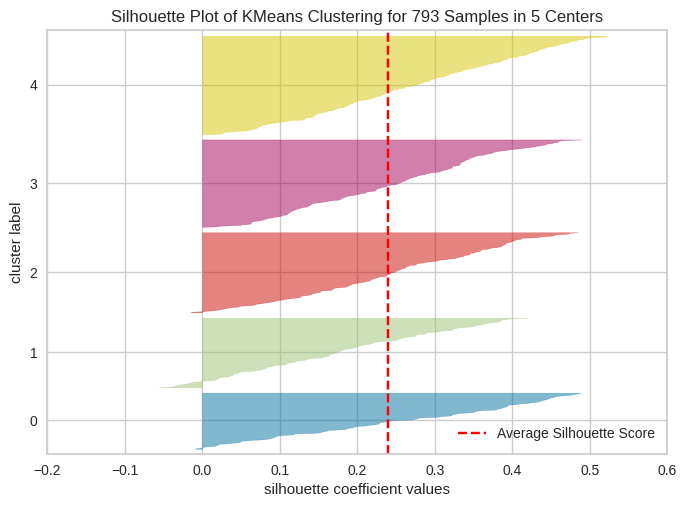

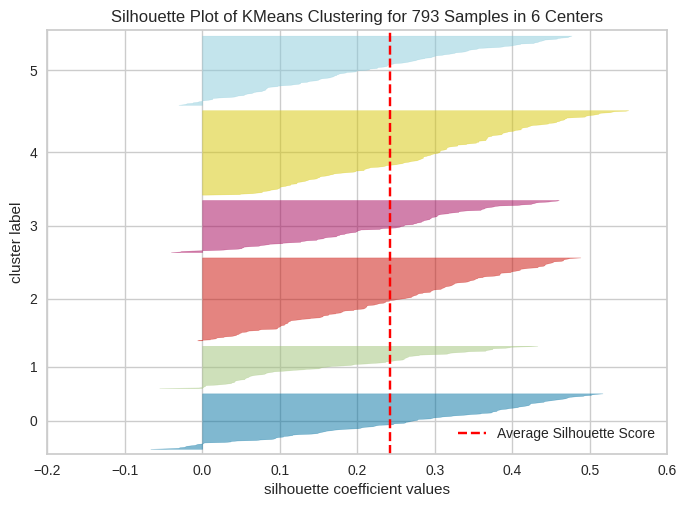

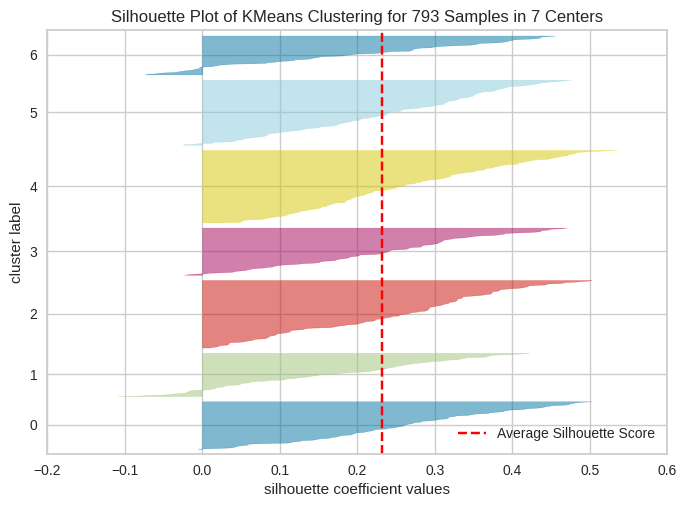

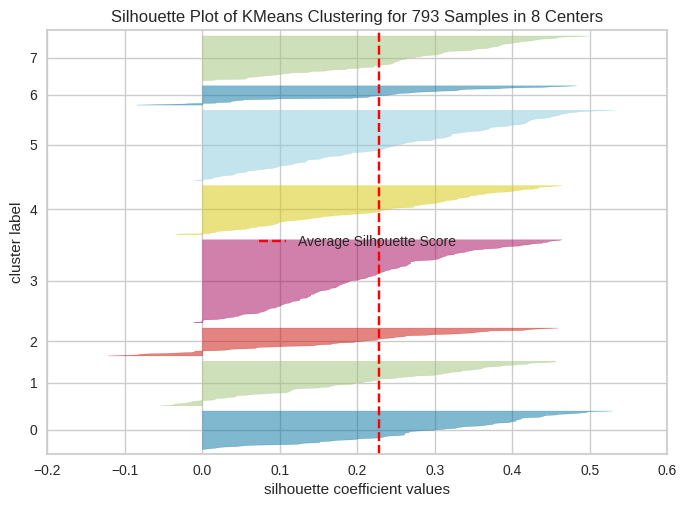

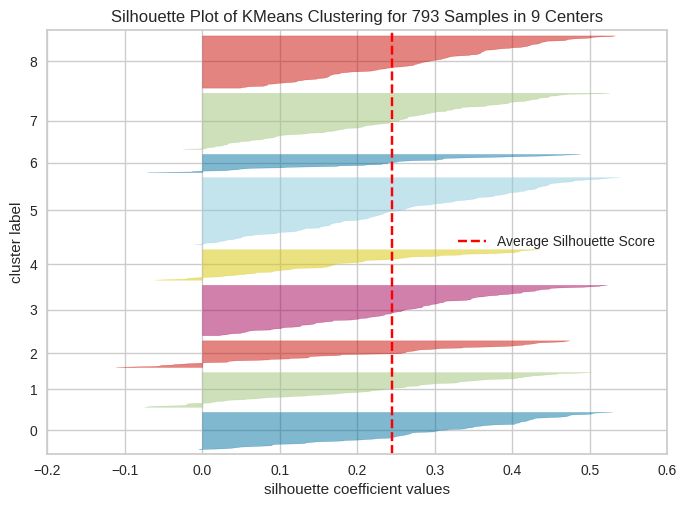

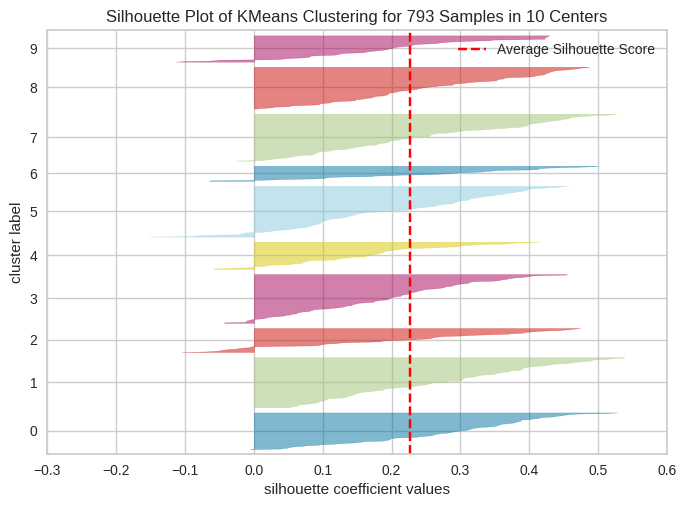

In [ ]:
#Kmeans Model

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

inertias = {}
silhouettes = {}
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(df_rfm_clean)
    inertias[k] = model.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(df_rfm_clean, model.labels_, metric='euclidean')

    # Plot silhouette score
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(df_rfm_clean)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

Text(0, 0.5, 'Silhouette')

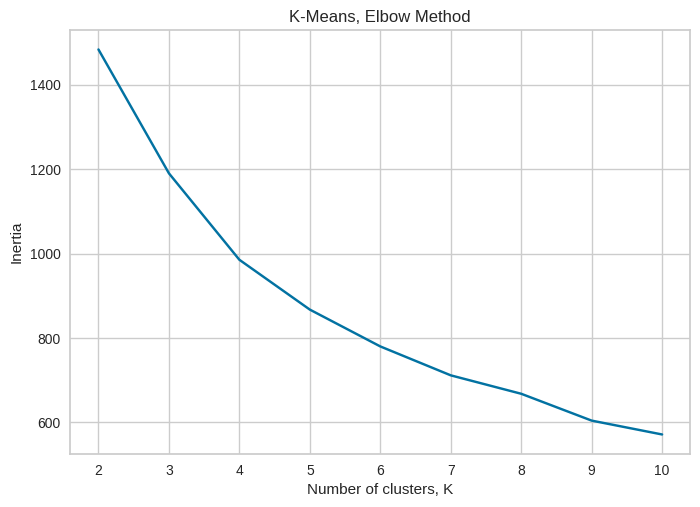

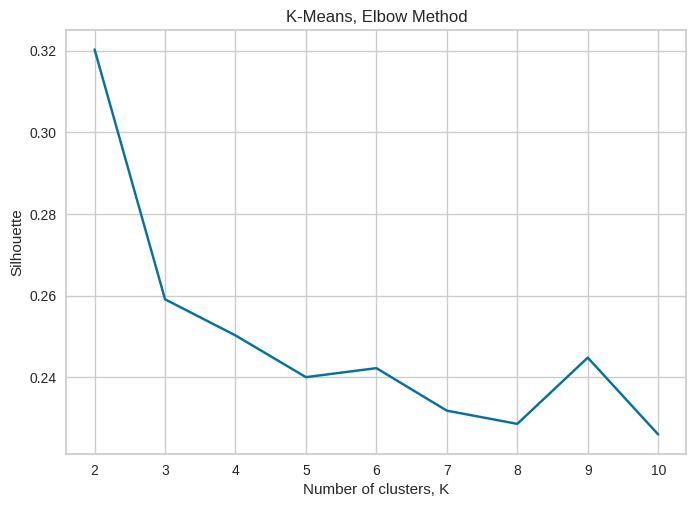

In [ ]:
plt.figure()
plt.plot(list(inertias.keys()), list(inertias.values()))
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K")
plt.ylabel("Inertia")


plt.figure()
plt.plot(list(silhouettes.keys()), list(silhouettes.values()))
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K")
plt.ylabel("Silhouette")

* based on silhouette plot using Yellowbricks and the elbow plot, cluster of 4 or 5 is optimal


In [ ]:
# model with 4 clusters
k = 4

model = KMeans(n_clusters=k, random_state=1)
model.fit(df_rfm_clean)

KMeans(n_clusters=4, random_state=1)

In [ ]:
df_rfm_clean_kmeans = df_rfm_clean.copy()
df_rfm_cluster_kmeans = df_rfm_cluster.copy()

In [ ]:
df_rfm_cluster_kmeans['cluster_label'] = model.labels_

In [ ]:
df_rfm_cluster_kmeans

,Customer Name,Recency,Frequency,Monetary,frequency_yj,recency_yj,monetary_yj,cluster_label
0,Aaron Bergman,415,6,1984.480,-1.118419,1.422079,-1.251270,0
1,Aaron Hawkins,12,11,11459.552,-0.127489,-1.279994,0.136221,2
2,Aaron Smayling,88,10,9088.880,-0.302776,0.100517,-0.081831,1
3,Adam Bellavance,54,18,35390.580,0.910526,-0.270888,1.385767,3
4,Adam Hart,34,20,9664.265,1.163972,-0.603335,-0.025241,3
...,...,...,...,...,...,...,...,...
788,Xylona Preis,43,28,8676.214,2.056637,-0.436946,-0.124126,3
789,Yana Sorensen,9,12,46478.992,0.039425,-1.448004,1.741215,3
790,Yoseph Carroll,4,8,27208.926,-0.683774,-1.870686,1.063960,2
791,Zuschuss Carroll,54,31,40212.889,2.353461,-0.270888,1.549508,3


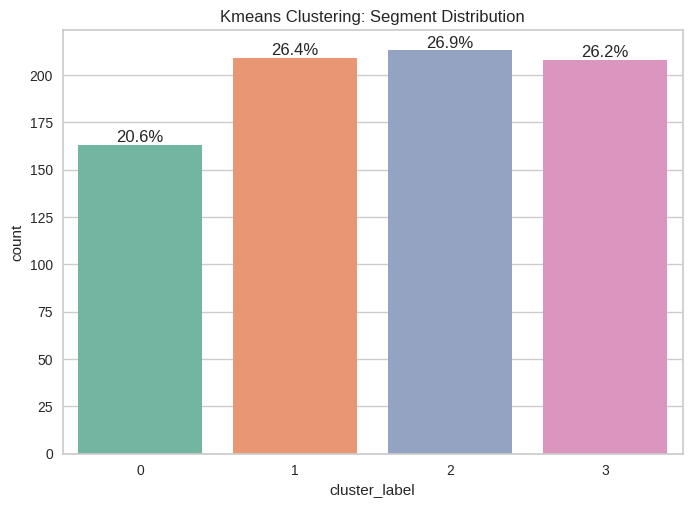

In [ ]:
# Plot cluster distribution
total = len(df_rfm_cluster_kmeans)

ax = sns.countplot(data=df_rfm_cluster_kmeans, x='cluster_label', palette='Set2')

for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')

plt.title('Kmeans Clustering: Segment Distribution')

plt.show()

In [ ]:
# cluster centers
df_rfm_cluster_kmeans.groupby(by=['cluster_label'], as_index=True)[['Recency','Frequency','Monetary']].mean().round(2).sort_values(by='cluster_label')

,Recency,Frequency,Monetary
cluster_label,,,
0,295.09,5.71,3048.01
1,227.31,12.04,12764.79
2,26.88,11.45,9523.02
3,72.50,19.75,30264.39


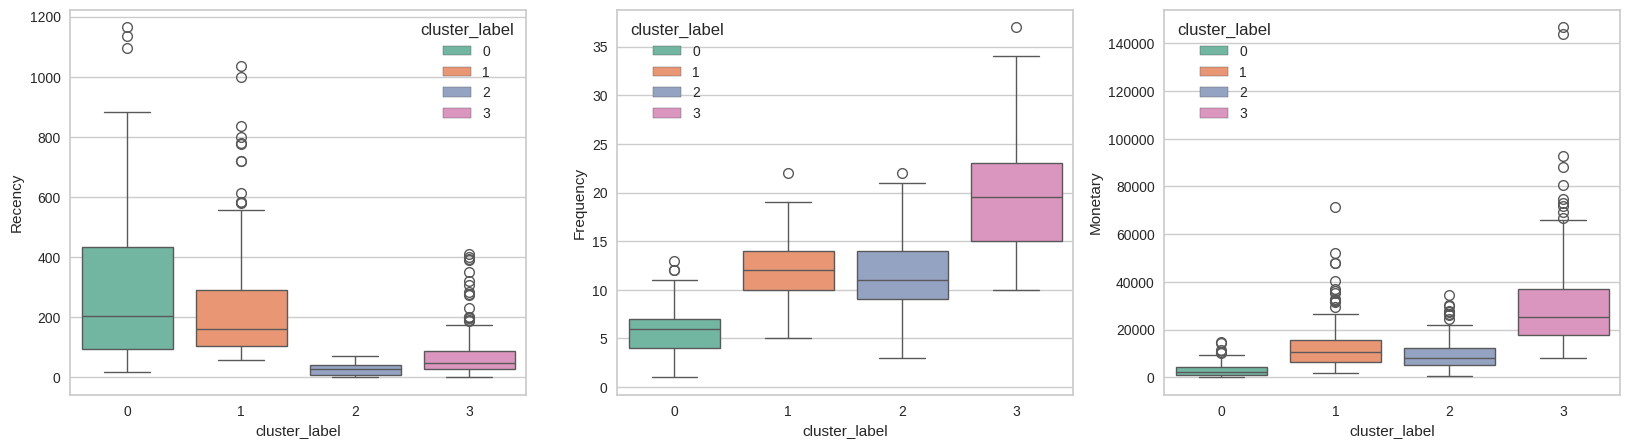

In [ ]:
# analyze RFM of each cluster
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(x = 'cluster_label', y = 'Recency', data = df_rfm_cluster_kmeans, ax=axs[0], hue='cluster_label', palette='Set2')
sns.boxplot(x = 'cluster_label', y = 'Frequency', data = df_rfm_cluster_kmeans, ax=axs[1], hue='cluster_label', palette='Set2')
sns.boxplot(x = 'cluster_label', y = 'Monetary', data = df_rfm_cluster_kmeans, ax=axs[2], hue='cluster_label', palette='Set2')

plt.show()


Observation:
*   **cluster 0** - Not recent but large discrepancy among customers, not frequent buyers, very low monetary value --> **Churned customer**
*   **cluster 1** - Not recent but large discrepancy among customers, highly frequent buyers, medium monetary value --> **Churning customers, should try to retain as they used to be recent frequent buyers with medium basket size**
*   **cluster 2** - Most recent, highly frequent, medium monetary value --> **New customers/Recent Frequent buyers with medium basket size**
*   **cluster 3** - Recent, most frequent, high monetary value --> **Top customers/Recent Frequent buyers with large basket size**

In [ ]:
cluster_name = ['Churned Customers', 'Churning Customers', 'Recent Frequent buyers, small basket', 'Recent Frequent buyers, large basket']
df_rfm_cluster_kmeans['cluster_name'] = df_rfm_cluster_kmeans['cluster_label'].replace([0,1,2,3], cluster_name)

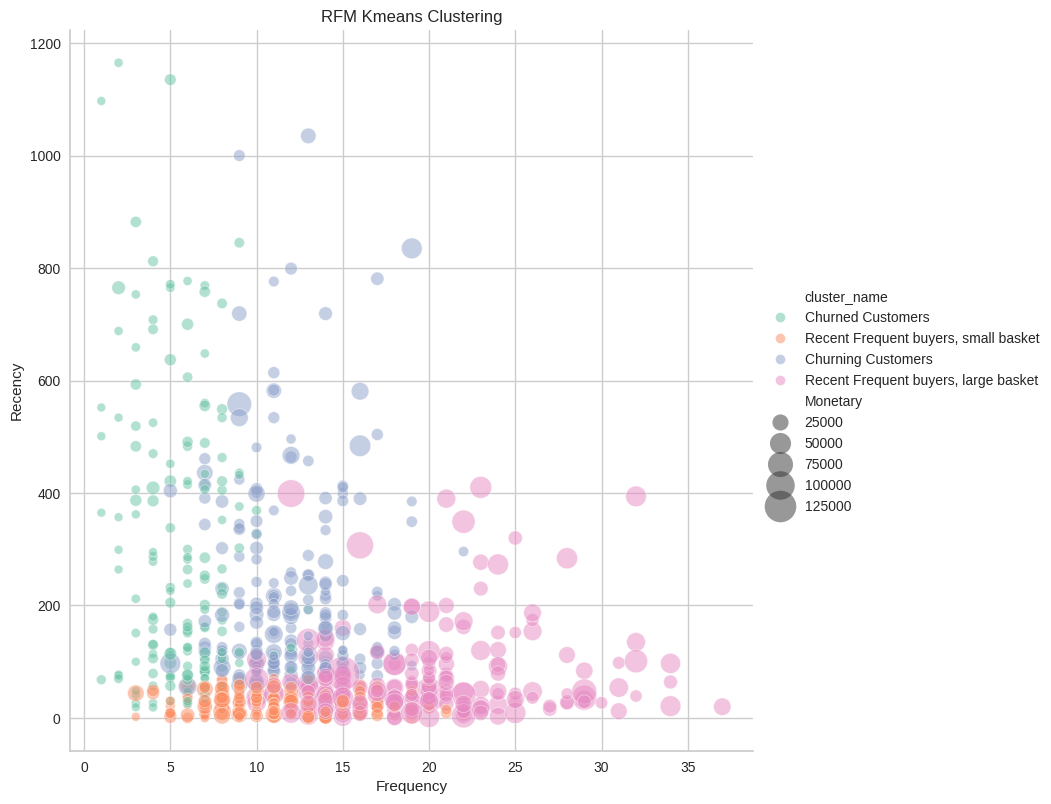

In [ ]:
sns.relplot(data=df_rfm_cluster_kmeans, x="Frequency", y="Recency", size="Monetary",
            hue="cluster_name",
            sizes=(40, 600),alpha=.5, palette="Set2", height=8)
plt.title('RFM Kmeans Clustering')
plt.show()

## Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

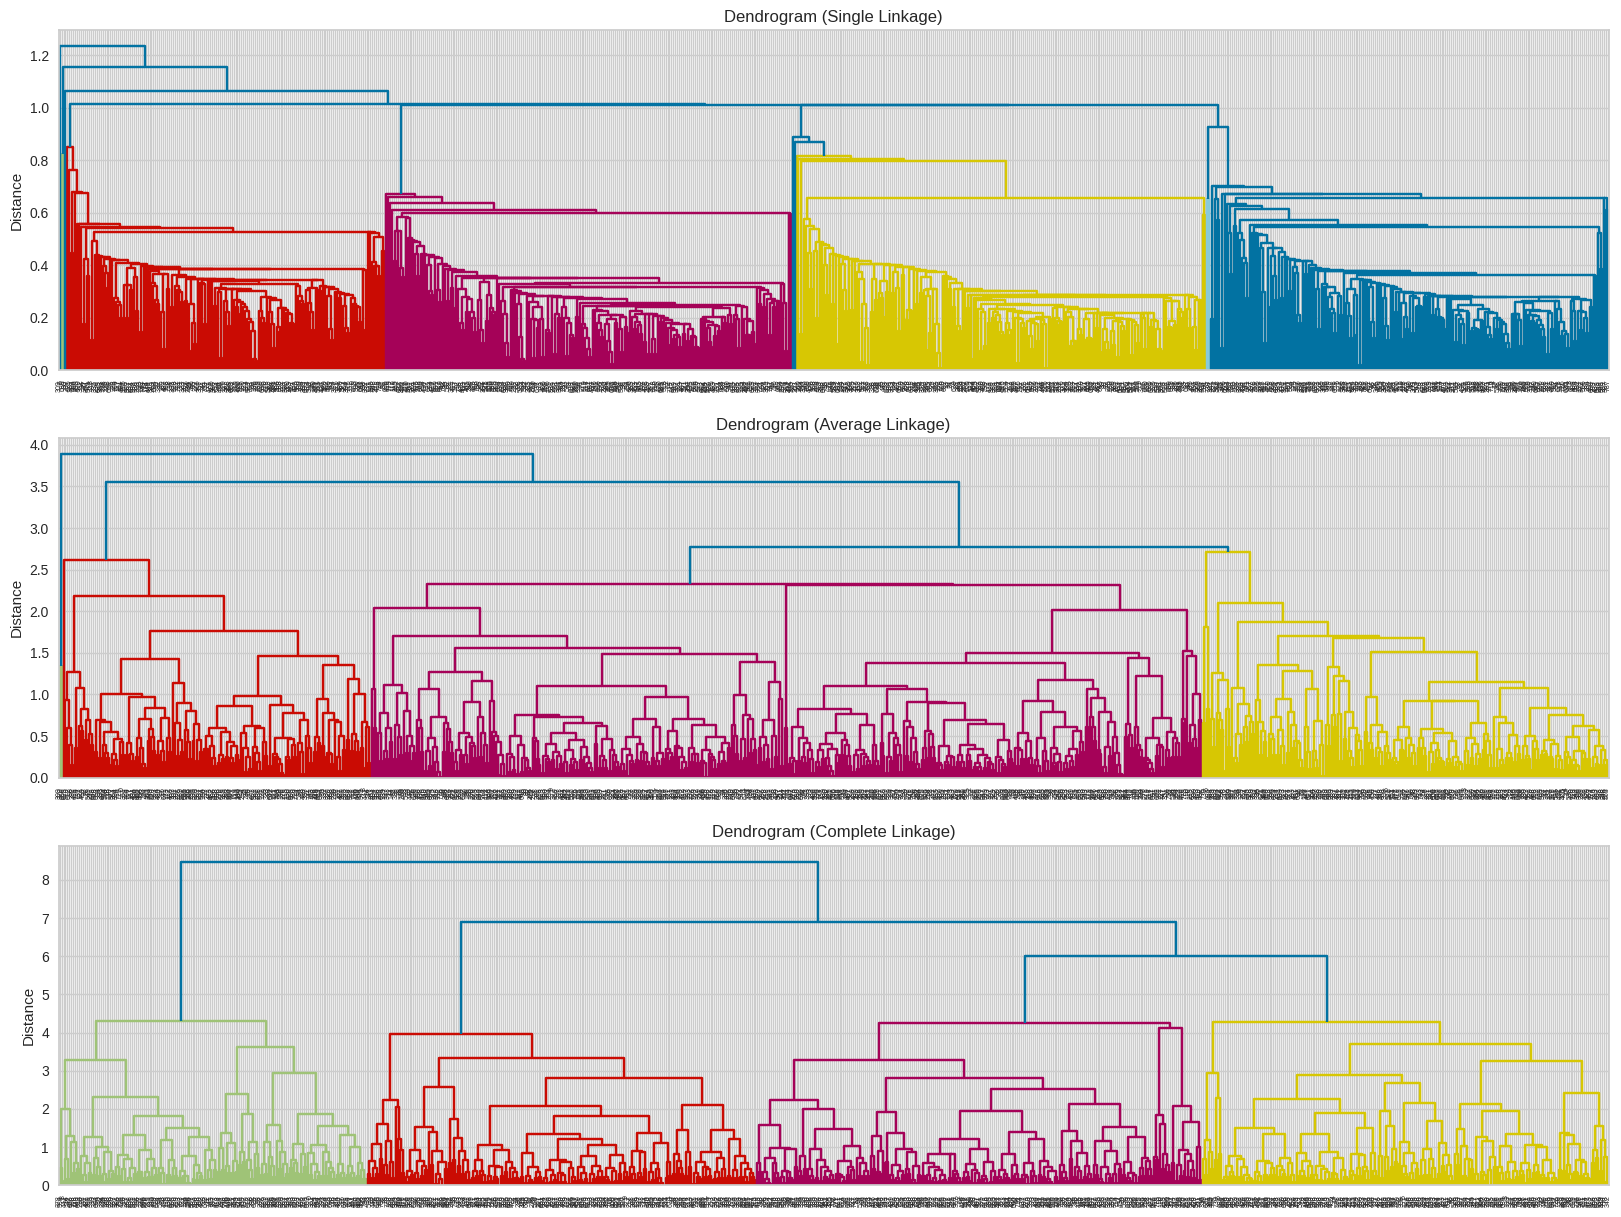

In [ ]:
# The List of all linkage methods to check
methods = ['single',
           'average',
           'complete']

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize = (20, 15))

# Enumerate through the list of all methods above, get linkage and plot dendrogram
for i, method in enumerate(methods):
    Z = linkage(df_rfm_clean, metric = 'euclidean', method = method)

    dendrogram(Z, ax = axs[i]);

    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')

    axs[i].set_ylabel('Distance')

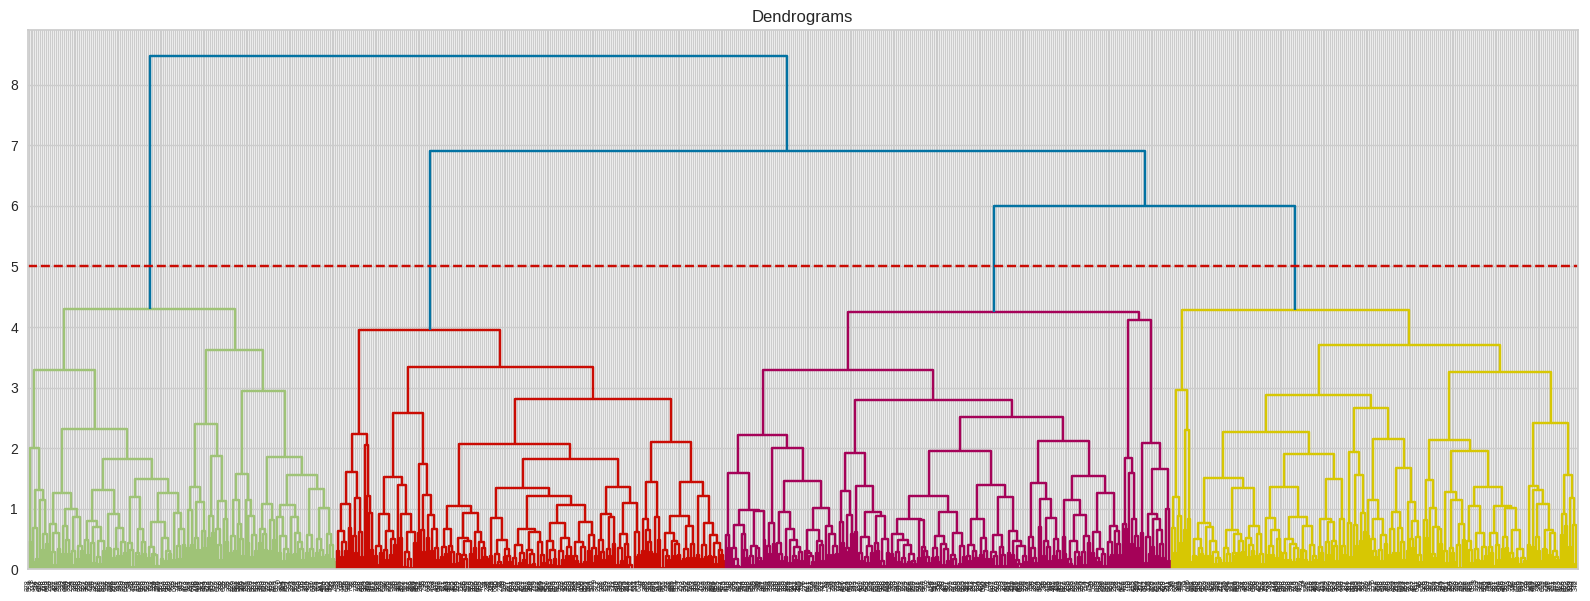

In [ ]:
# complete linkage is the most suitable method

plt.figure(figsize = (20, 7))

plt.title("Dendrograms")

dend = dendrogram(linkage(df_rfm_clean, method = 'complete'))

plt.axhline(y = 5, color = 'r', linestyle = '--')

In [ ]:
# Model with 4 clusters
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters = 4,  linkage = 'complete')

hierarchical.fit(df_rfm_clean)

AgglomerativeClustering(linkage='complete', n_clusters=4)

In [ ]:
df_rfm_cluster_hierarchical = df_rfm_cluster.copy()

In [ ]:
df_rfm_cluster_hierarchical['cluster_label'] = hierarchical.labels_
df_rfm_cluster_hierarchical.head(5)

,Customer Name,Recency,Frequency,Monetary,frequency_yj,recency_yj,monetary_yj,cluster_label
0,Aaron Bergman,415,6,1984.480,-1.118419,1.422079,-1.251270,0
1,Aaron Hawkins,12,11,11459.552,-0.127489,-1.279994,0.136221,2
2,Aaron Smayling,88,10,9088.880,-0.302776,0.100517,-0.081831,3
3,Adam Bellavance,54,18,35390.580,0.910526,-0.270888,1.385767,1
4,Adam Hart,34,20,9664.265,1.163972,-0.603335,-0.025241,1


In [ ]:
cols = ['Recency','Frequency','Monetary','cluster_label']
mean = df_rfm_cluster_hierarchical[cols].groupby('cluster_label').mean()
mean

,Recency,Frequency,Monetary
cluster_label,,,
0,300.544304,5.525316,3089.025658
1,72.500000,19.745192,30264.393289
2,26.035176,11.778894,8767.453619
3,213.451754,11.710526,12983.679577


In [ ]:
# Calculating the mean and the median of the original data for each label
original_features  = ['Recency','Frequency','Monetary']
cols = original_features + ['cluster_label']
mean = df_rfm_cluster_hierarchical[cols].groupby('cluster_label').mean()
median = df_rfm_cluster_hierarchical[cols].groupby('cluster_label').median()

df_hierachical = pd.concat([mean, median], axis = 0)

df_hierachical.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median']

df_hierachical[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_3 Mean,group_0 Median,group_1 Median,group_2 Median,group_3 Median
Recency,195.337778,94.559524,217.081633,15.785714,114.0000,53.5000,79.000,12.000
Frequency,11.622222,18.630952,3.755102,11.507937,11.0000,18.0000,4.000,11.000
Monetary,8831.628432,34838.733213,907.725143,12828.917187,7542.2825,29919.2735,677.934,11133.751


## RFM Clustering Plot

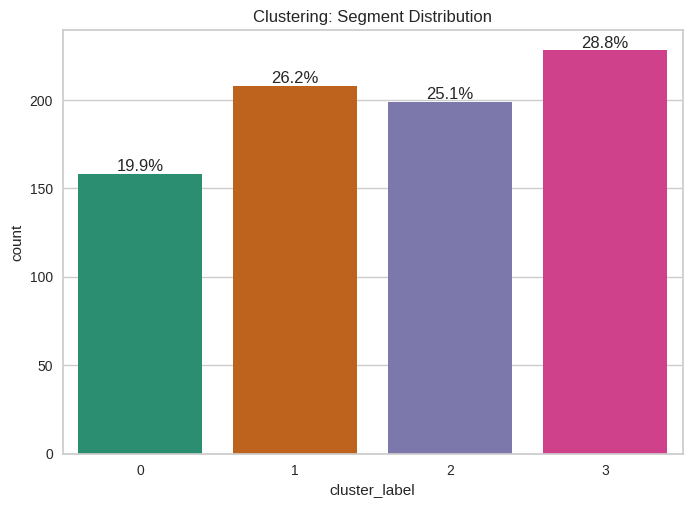

In [ ]:
total = len(df_rfm_cluster)

ax = sns.countplot(data=df_rfm_cluster_hierarchical, x='cluster_label', palette='Dark2')

for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')

plt.title('Hierarchical Clustering: Segment Distribution')

plt.show()

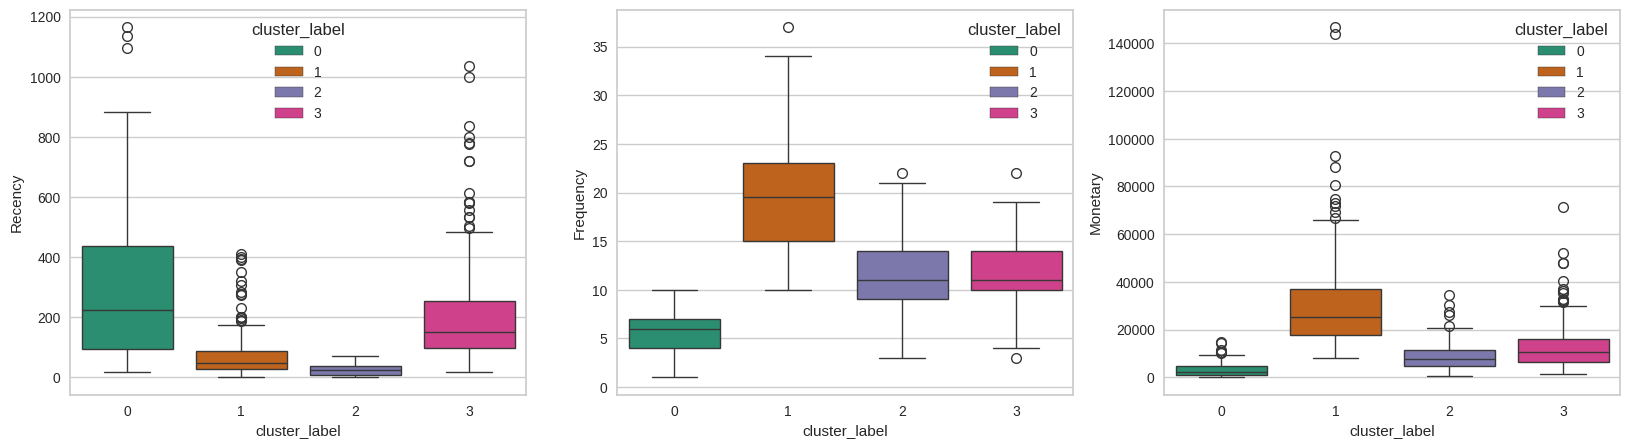

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(x = 'cluster_label', y = 'Recency', data = df_rfm_cluster_hierarchical, ax=axs[0], hue='cluster_label', palette='Dark2')
sns.boxplot(x = 'cluster_label', y = 'Frequency', data = df_rfm_cluster_hierarchical, ax=axs[1], hue='cluster_label', palette='Dark2')
sns.boxplot(x = 'cluster_label', y = 'Monetary', data = df_rfm_cluster_hierarchical, ax=axs[2], hue='cluster_label', palette='Dark2')

plt.show()



*   **cluster 0** - Not recent but large discrepancy among customers, not frequent buyers, low monetary value --> **Churned customer"**
*   **cluster 1** - Rrecent, Most frequent, Most monetary value --> **Top customers/Recent Frequent buyers with lage basket size**
*   **cluster 2** - Most recent, highly frequent buyers, low monetary value --> **New customers/Recent Frequent buyers with medium basket size**
*   **cluster 3** - Not recent but large discrepancy among customers, highly frequent, medium monetary value --> **Churning customers**


In [ ]:
cluster_name = ['Churned Customers', 'Recent Frequent buyers, lagre basket', 'Recent Frequent buyers, medium basket', 'Churning customers']
df_rfm_cluster_hierarchical['cluster_name'] = df_rfm_cluster_hierarchical['cluster_label'].replace([0,1,2,3], cluster_name)

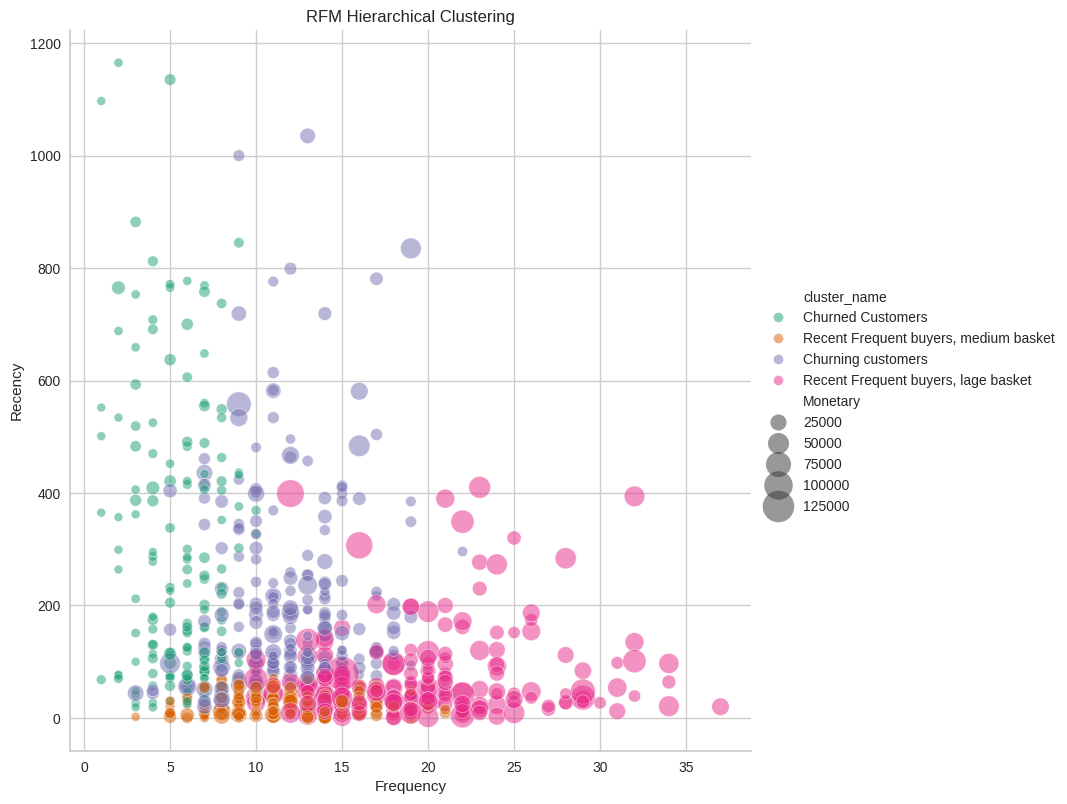

In [ ]:
sns.relplot(data=df_rfm_cluster_hierarchical, x="Frequency", y="Recency", size="Monetary",
            hue="cluster_name",
            sizes=(40, 600),alpha=.5, palette="Dark2", height=8)
plt.title('RFM Hierarchical Clustering')
plt.show()

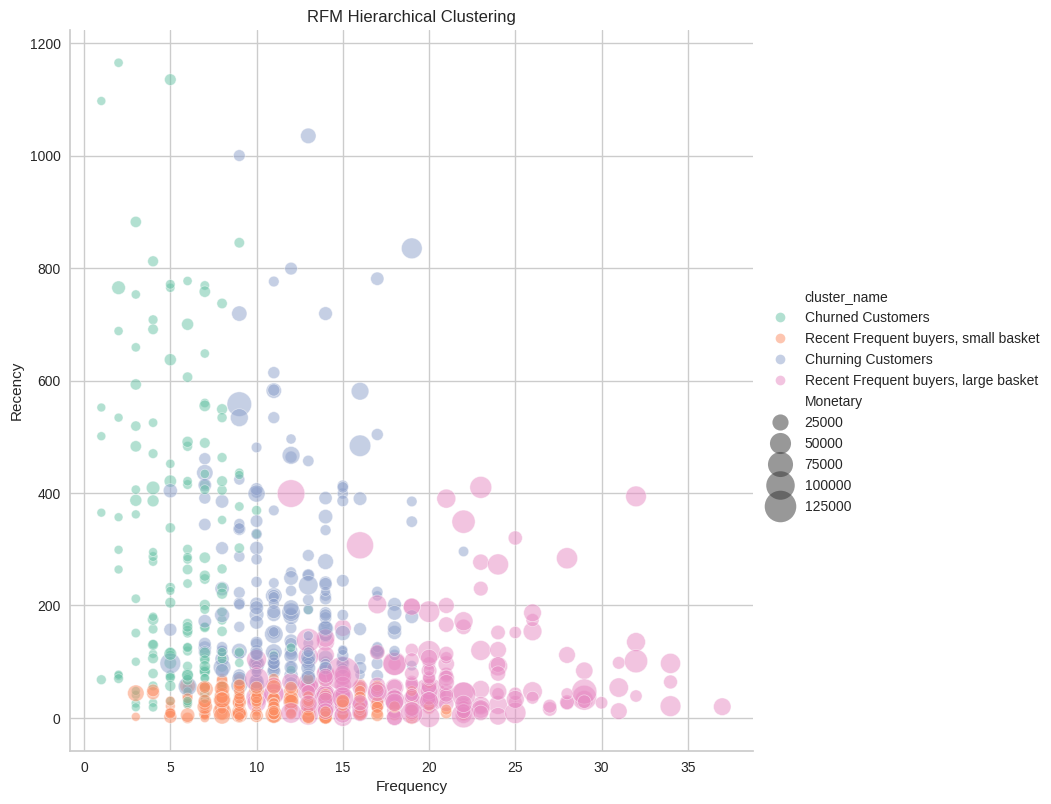

In [ ]:
sns.relplot(data=df_rfm_cluster_kmeans, x="Frequency", y="Recency", size="Monetary",
            hue="cluster_name",
            sizes=(40, 600),alpha=.5, palette="Set2", height=8)
plt.title('RFM Kmeans Clustering')
plt.show()

In [ ]:
# hierarchical cluster centers
df_rfm_cluster_hierarchical.groupby(by=['cluster_name'], as_index=True)[['Recency','Frequency','Monetary']].mean().round(2).sort_values(by='cluster_name')

,Recency,Frequency,Monetary
cluster_name,,,
Churned Customers,300.54,5.53,3089.03
Churning customers,213.45,11.71,12983.68
"Recent Frequent buyers, lage basket",72.50,19.75,30264.39
"Recent Frequent buyers, medium basket",26.04,11.78,8767.45


In [ ]:
# kmeans cluster centers
df_rfm_cluster_kmeans.groupby(by=['cluster_name'], as_index=True)[['Recency','Frequency','Monetary']].mean().round(2).sort_values(by='cluster_name')

,Recency,Frequency,Monetary
cluster_name,,,
Churned Customers,295.09,5.71,3048.01
Churning Customers,227.31,12.04,12764.79
"Recent Frequent buyers, large basket",72.50,19.75,30264.39
"Recent Frequent buyers, small basket",26.88,11.45,9523.02


**RFM Scoring (Quartile-Based Ranking)**

*   Easy to implement and interpret, making it accessible for business stakeholders.
*  Rule-Based & Transparent: Allows manual control over segmentation by defining score ranges.

**Clustering**
*   Kmeans & hierarchical produced similar results
*   Clustering method is able to identify groupings without pre-defined rules
*   Clustering captures non linear relationship, segments such as "new customers" and "churning customers"





# Strategic Recommendation:

## 1. Churned Customers

**Goal: Reactivate these customers and bring them back to purchasing.**

* Re-engagement Campaigns: Send personalized emails with exclusive offers (e.g., "We Miss You! Enjoy 20% Off Your Next Purchase").
* Win-Back Discounts: Provide targeted discounts for previous purchases or related products.
Survey & Feedback Collection: Understand why they stopped buying through a quick survey in exchange for a small incentive.
* Retargeting Ads: Use digital ads to remind them of past purchases or showcase new arrivals.
Subscription/Loyalty Program Promotions: Encourage them to re-engage with a small reward or free trial offer.

## 2. Churning Customers
**Goal: Prevent churn and increase engagement before they leave.**
* Exclusive VIP Offers: Offer loyalty perks like early access to sales or free shipping.
* Personalized Product Recommendations: Use past purchase data to recommend related or complementary items.
* Limited-Time Offers: Provide time-sensitive discounts or bundle deals to create urgency.
* Engagement Reminders: Send reminders like “You’ve Loved These Before – Ready for More?” with past purchase history.
* Loyalty Program Optimization: Reward repeat purchases or offer a bonus if they return within a certain timeframe.

## 3. Recent Frequent Buyers (Large Basket Size)

**Goal: Retain and increase customer lifetime value (CLV).**
* Premium Membership Upsell: Offer free shipping, exclusive discounts, or subscription services.
* Cross-Selling & Bundling: Recommend high-value add-ons and complementary products.
* Personalized Rewards: Provide tiered incentives (e.g., “Spend $X more for an extra discount”).
* Early Access to New Products: Make them feel valued by giving early access to new collections.
* Referral Program: Encourage them to bring friends with incentives like discounts for both referrer and referee.

## 4. Recent Frequent Buyers (Small Basket Size)
**Goal: Encourage higher spend per transaction.**
* Upsell Higher-Ticket Items: Highlight premium versions of products they typically buy.
* Bundle & Volume Discounts: Offer “Buy More, Save More” deals to encourage larger basket sizes.
* Subscription Options: If applicable, introduce subscription models for frequently purchased items.
* Loyalty Program Enrollment: Encourage repeat purchases by providing points for larger purchases.
* A/B Testing Promotions: Test different price-based incentives to see which increases order size.
